### 1. Import necessary libraries and modules

In [106]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import requests 
import json
from pandas.io.json import json_normalize

%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

import pylab as pl
import matplotlib.pyplot as plt 

import sklearn
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score

! conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

! conda install -c conda-forge folium=0.5.0 --yes
import folium

! conda install mlxtend --channel conda-forge --yes 
from mlxtend.plotting import plot_decision_regions 

print("All libraries imported")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - mlxtend


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-0.14.1              |             py_0         198 KB  conda-forge
    mlxtend-0.17.2             |             py_0         1.2 MB  conda-forge
    scikit-learn-0.22.2.post1  |   py36hcdab131_0         7.1 MB  conda-forge
    scipy-1.4.1                |   py36h2d22cac_3        18.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        27.4 MB

The following NEW packages will be INSTALLED:

  joblib             conda-forge/noarch::joblib-0.14.1-py_0
  mlxtend     

### 2. Loading GeoJson

In [2]:
with open('nyc_geojson.json') as json_data:
    nyc_cords= json.load(json_data)
    
neighborhood_cords= nyc_cords ['features']

### 3. Set up dataframe for GeoJson

In [3]:
column_names= ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

nyc_hoods= pd.DataFrame(columns=column_names)
nyc_hoods

,Borough,Neighborhood,Latitude,Longitude


In [4]:
for cords in neighborhood_cords:
    borough= hood_name= cords['properties'] ['borough']
    hood_name= cords['properties'] ['name']
    
    hood_latlng= cords['geometry'] ['coordinates']
    hood_lat= hood_latlng[1]
    hood_lng= hood_latlng[0]
    
    nyc_hoods= nyc_hoods.append({'Borough': borough,
                        'Neighborhood': hood_name,
                        'Latitude': hood_lat,
                        'Longitude': hood_lng}, ignore_index=True)

print(nyc_hoods.shape)
nyc_hoods.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### 4. Narrow down GeoJson data to Manhattan borough

In [5]:
man_hoods= nyc_hoods[nyc_hoods['Borough'] == 'Manhattan'].reset_index(drop=True)
print(man_hoods.shape)
man_hoods.head()

(40, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### 5. Load Foursquare API authentication info and some parameters

In [16]:
CLIENT_ID= 'G2IDKV2T43SF5MNWBLGYK3QQWF4ZDPZ2MD1V03OMSGFP4PNS' 
CLIENT_SECRET= 'ROQGKEXKPCJWCXEH4D1WGL24NC1OTZHKCZR2ECQSIWYMEWRF'
VERSION= '20180605'

CATEGORY_ID= '4bf58dd8d48988d10f951735'

RADIUS= 500
LIMIT= 5

print("4S login info")

4S login info


### 6. Define function for retrieving five most popular pharmacies in each neighborhood. I did this by defining in the url parameters the Venue Category Id for "pharmacy", and, to return results sorted by most popular (most checkins).

In [42]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}&sortByPopularity=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            CATEGORY_ID,
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues) 

In [13]:
man_venues = getNearbyVenues(names=man_hoods['Neighborhood'],
                               latitudes=man_hoods['Latitude'],
                               longitudes=man_hoods['Longitude']
                              )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [14]:
print(man_venues.shape)
man_venues.head()

(185, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,4a0eb511f964a520ea751fe3,Target,40.873437,-73.907726,Big Box Store
1,Marble Hill,40.876551,-73.91066,4b88e053f964a5208a1132e3,Rite Aid,40.875467,-73.908906,Pharmacy
2,Marble Hill,40.876551,-73.91066,572ba48f498e3a5e175667e3,marble hill pharmacy,40.875050,-73.909195,Pharmacy
3,Marble Hill,40.876551,-73.91066,5238d84111d24b6f1f1cff13,Drug Mart,40.873824,-73.907391,Pharmacy
4,Marble Hill,40.876551,-73.91066,5631194e498e2de074de661c,Vitamin Shoppe,40.877160,-73.905632,Pharmacy


### 7. To avoid making unecessary API calls, I exported the Foursquare dataframe into a static csv, which I could recall as needed. 

In [17]:
man_venues.to_csv(r'Coursera_Capstone\man_venues.csv',index=False)

In [6]:
man_venues= pd.read_csv("Coursera_Capstone\man_venues.csv")
man_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,4a0eb511f964a520ea751fe3,Target,40.873437,-73.907726,Big Box Store
1,Marble Hill,40.876551,-73.91066,4b88e053f964a5208a1132e3,Rite Aid,40.875467,-73.908906,Pharmacy
2,Marble Hill,40.876551,-73.91066,572ba48f498e3a5e175667e3,marble hill pharmacy,40.875050,-73.909195,Pharmacy
3,Marble Hill,40.876551,-73.91066,5238d84111d24b6f1f1cff13,Drug Mart,40.873824,-73.907391,Pharmacy
4,Marble Hill,40.876551,-73.91066,5631194e498e2de074de661c,Vitamin Shoppe,40.877160,-73.905632,Pharmacy


### 8. Here, I cleaned up API-retrieved data by limiting category to pharmacy and by removing locations that were labeled "pharmacy" but do not offer doctor-written prescriptions. 

In [7]:
man_pharma= man_venues[man_venues['Venue Category'].str.contains("Pharmacy")]
man_pharma.drop(man_pharma.loc[man_pharma['Venue']== 'The Vitamin Shoppe'].index, inplace=True)
man_pharma.drop(man_pharma.loc[man_pharma['Venue']== 'Vitamin Shoppe'].index, inplace=True)
man_pharma.drop(man_pharma.loc[man_pharma['Venue']== '(MALIN+GOETZ) (MALIN+GOETZ)'].index, inplace=True)
man_pharma.drop(man_pharma.loc[man_pharma['Venue']== 'Harmon Face Values'].index, inplace=True)
man_pharma.drop(man_pharma.loc[man_pharma['Venue']== 'Kamwo Meridian Herbs'].index, inplace=True)

print(man_pharma.shape)
man_pharma.head()

(169, 8)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Marble Hill,40.876551,-73.910660,4b88e053f964a5208a1132e3,Rite Aid,40.875467,-73.908906,Pharmacy
2,Marble Hill,40.876551,-73.910660,572ba48f498e3a5e175667e3,marble hill pharmacy,40.875050,-73.909195,Pharmacy
3,Marble Hill,40.876551,-73.910660,5238d84111d24b6f1f1cff13,Drug Mart,40.873824,-73.907391,Pharmacy
6,Chinatown,40.715618,-73.994279,4ce07dad3644a093b54f589f,Hester Pharmacy Corp,40.717413,-73.995772,Pharmacy
7,Chinatown,40.715618,-73.994279,50d8e9b2830252feb10cd1c6,Manhattan Chinatown Pharmacy,40.716328,-73.996653,Pharmacy


### 9. I also added a column for "Chain" and "Independent" pharmacies after looking at the data and intuiting that some analysis could be run based on that distinction.

In [8]:
# First create a dictionary of manually stored values
chain_dict = {'Duane Reade':'Chain', 'CVS Pharmacy':'Chain', 'CVS pharmacy':'Chain', 'Rite Aid':'Chain', 'Walgreens':'Chain', 'RiteAid':'Chain', 'CVS':'Chain'}
chain_dict_other = {x:'Independent' for x in man_pharma['Venue'].unique() if x not in chain_dict.keys()}
chain_dict.update(chain_dict_other)
man_pharma['Chain/Indep'] = man_pharma['Venue'].map(chain_dict)
man_pharma.reset_index(inplace=True, drop=True)

print(man_pharma.shape)
print(man_pharma['Chain/Indep'].value_counts())
man_pharma.head()

(169, 9)
Chain          119
Independent     50
Name: Chain/Indep, dtype: int64


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Chain/Indep
0,Marble Hill,40.876551,-73.910660,4b88e053f964a5208a1132e3,Rite Aid,40.875467,-73.908906,Pharmacy,Chain
1,Marble Hill,40.876551,-73.910660,572ba48f498e3a5e175667e3,marble hill pharmacy,40.875050,-73.909195,Pharmacy,Independent
2,Marble Hill,40.876551,-73.910660,5238d84111d24b6f1f1cff13,Drug Mart,40.873824,-73.907391,Pharmacy,Independent
3,Chinatown,40.715618,-73.994279,4ce07dad3644a093b54f589f,Hester Pharmacy Corp,40.717413,-73.995772,Pharmacy,Independent
4,Chinatown,40.715618,-73.994279,50d8e9b2830252feb10cd1c6,Manhattan Chinatown Pharmacy,40.716328,-73.996653,Pharmacy,Independent


### 10. Loading map location data

In [9]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent= "ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Manhattan are 40.7896239, -73.9598939.


### 11. Map to visualize all the five most popular pharmacies in each neighborhood

In [10]:
# create map of Manhattan using latitude and longitude values
man_pharma_map1 = folium.Map(location=[latitude, longitude], zoom_start=12)


# add markers to map
for lat, lng, venue, hood, kind in zip(man_pharma['Venue Latitude'], man_pharma['Venue Longitude'], man_pharma['Venue'], man_pharma['Neighborhood'], man_pharma['Chain/Indep']):
    label = folium.Popup(str(hood)+ str(', ') +str(venue), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color= 'black',
        fill=True,
        fill_color= 'black',
        fill_opacity=0.7,
        parse_html=False).add_to(man_pharma_map1)  
    
man_pharma_map1

### 12. Here's the same map that distinguishes between chain and independent pharmacies. More on this later.

In [11]:
# create map of Manhattan using latitude and longitude values
man_pharma_map = folium.Map(location=[latitude, longitude], zoom_start=12)


# add markers to map
for lat, lng, venue, hood, kind in zip(man_pharma['Venue Latitude'], man_pharma['Venue Longitude'], man_pharma['Venue'], man_pharma['Neighborhood'], man_pharma['Chain/Indep']):
    label = folium.Popup(str(hood)+ str(', ') +str(venue), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color= 'red' if kind == 'Independent' else 'blue',
        fill=True,
        fill_color= 'red' if kind == 'Independent' else 'blue',
        fill_opacity=0.7,
        parse_html=False).add_to(man_pharma_map)  
    
man_pharma_map

In [12]:
man_nextvenues = man_pharma
print(man_nextvenues.shape)
man_nextvenues.head()

(169, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Chain/Indep
0,Marble Hill,40.876551,-73.910660,4b88e053f964a5208a1132e3,Rite Aid,40.875467,-73.908906,Pharmacy,Chain
1,Marble Hill,40.876551,-73.910660,572ba48f498e3a5e175667e3,marble hill pharmacy,40.875050,-73.909195,Pharmacy,Independent
2,Marble Hill,40.876551,-73.910660,5238d84111d24b6f1f1cff13,Drug Mart,40.873824,-73.907391,Pharmacy,Independent
3,Chinatown,40.715618,-73.994279,4ce07dad3644a093b54f589f,Hester Pharmacy Corp,40.717413,-73.995772,Pharmacy,Independent
4,Chinatown,40.715618,-73.994279,50d8e9b2830252feb10cd1c6,Manhattan Chinatown Pharmacy,40.716328,-73.996653,Pharmacy,Independent


### 13. After cleaning the venue data, we will make another Foursquare API call with each Venue Id to retrieve the five most popular venues users are checked into after visiting the current pharmacy.

In [ ]:
def getNextVenues(hoods, venues, ids):
    
    nextvenues_list=[]
    for hood, venue, identifier in zip(hoods, venues, ids):
        
        # create the API request URL
        url1 = 'https://api.foursquare.com/v2/venues/{}/nextvenues?&client_id={}&client_secret={}&v={}&sortByPopularity=1'.format(
        identifier,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION
        )
            
        # make the GET request
        resp = requests.get(url1).json()
        results1 = resp["response"]                
     
        # return only relevant information for each nearby venue 
        for i in range(results1['nextVenues']['count']):
            nextVenue = results1['nextVenues']['items'][i]          
            nextvenues_list.append([hood, 
                                   venue, 
                                    identifier,
                                   nextVenue['name'],
                                   nextVenue['location']['lat'],
                                   nextVenue['location']['lng'],
                                   nextVenue['categories'][0]['name']]
                                  )
            
    next_venues = pd.DataFrame(nextvenues_list)
    
    return(next_venues) 

In [ ]:
man_newvenues = getNextVenues(hoods=man_nextvenues['Neighborhood'],
                               venues=man_nextvenues['Venue'],
                               ids=man_nextvenues['Venue Id']
                              )

In [ ]:
man_newvenues.columns = ['Neighborhood', 
                  'Pharmacy', 
                  'Venue Id',
                  'NextVenue', 
                  'NextVenue Latitude', 
                  'NextVenue Longitude', 
                  'NextVenue Category',]
man_newvenues.head()

### 14. Like the first Foursquare output dataframe, I exported this one as well into a static .csv for easy retrieval while working on this project.

In [ ]:
man_newvenues.to_csv(r'Coursera_Capstone\man_newvenues1.csv', index=False)

In [13]:
man_newvenues1= pd.read_csv("Coursera_Capstone\man_newvenues1.csv")
man_newvenues1.head()

,Neighborhood,Pharmacy,Venue Id,NextVenue,NextVenue Latitude,NextVenue Longitude,NextVenue Category
0,Marble Hill,Rite Aid,4b88e053f964a5208a1132e3,Target,40.873437,-73.907726,Big Box Store
1,Washington Heights,Rite Aid,4bc37855b492d13aeecca860,Dunkin',40.848344,-73.938039,Donut Shop
2,Washington Heights,Rite Aid,4bc37855b492d13aeecca860,Bravo Supermarkets,40.845860,-73.938213,Grocery Store
3,Washington Heights,Rite Aid,4bc37855b492d13aeecca860,Planet Fitness,40.847536,-73.937937,Gym / Fitness Center
4,Washington Heights,Rite Aid,4c6f1f54b5a5236ab45b4c52,Dan's Supermarket,40.851829,-73.932393,Supermarket


### 15. Slicing up the NextVenue data to understand the results by neighborhood. 
#### It's worth mentioning the limitations of the Foursquare dataset. For example, ideally there should have 25 next venues for each neighborhood (5 from each of the 5 pharmacies,) but not every pharmacy venue returned the full 5 NextVenues, and some did not return any NextVenues at all. So, we excluded the neighborhoods that returned less than 5 results. However, for the ones that did return, they are sorted by popularity. We will mean these out with each neighborhood having "equal weight" (if for some reason they would not bear equal weight for clustering, then we would want to normalize the data.)

In [14]:
print("Total Number of NextVenues:", man_newvenues1['NextVenue'].shape)
print("Number of pharmacies with at least one NextVenue:", man_newvenues1['Venue Id'].nunique())
man_newvenues1.groupby(['Neighborhood']).count().sort_values('NextVenue', ascending=False)

Total Number of NextVenues: (523,)
Number of pharmacies with at least one NextVenue: 106


,Pharmacy,Venue Id,NextVenue,NextVenue Latitude,NextVenue Longitude,NextVenue Category
Neighborhood,,,,,,
Murray Hill,25,25,25,25,25,25
Midtown,25,25,25,25,25,25
Yorkville,24,24,24,24,24,24
Midtown South,24,24,24,24,24,24
Sutton Place,23,23,23,23,23,23
Gramercy,22,22,22,22,22,22
Carnegie Hill,21,21,21,21,21,21
Greenwich Village,21,21,21,21,21,21
Lincoln Square,20,20,20,20,20,20


In [15]:
df= man_newvenues1.groupby([man_newvenues1['Venue Id']]).count()
df.shape

(106, 6)

### 16. As you can see below, there are 83 Categories of venues visited after the most popular pharmacies in each neighborhood. I visualized this data further down in this notebook.

In [16]:
man_newvenues1.drop(man_newvenues1.loc[man_newvenues1['Neighborhood']== 'Marble Hill'].index, inplace=True)
print("Number of Unique NextVenue Categories:", man_newvenues1['NextVenue Category'].nunique())
print("Total occurrances by Venue Category:")
man_newvenues1.groupby('NextVenue Category').count().sort_values('NextVenue', ascending=False).head()

Number of Unique NextVenue Categories: 84
Total occurrances by Venue Category:


,Neighborhood,Pharmacy,Venue Id,NextVenue,NextVenue Latitude,NextVenue Longitude
NextVenue Category,,,,,,
Grocery Store,69,69,69,69,69,69
Coffee Shop,57,57,57,57,57,57
Park,46,46,46,46,46,46
Supermarket,41,41,41,41,41,41
Pharmacy,37,37,37,37,37,37


### 17. Now we pre-process the data for KMeans Clustering by one-hot encoding each NextVenue Category by Neighborhood.

In [17]:
# one hot encoding
man_onehot = pd.get_dummies(man_newvenues1['NextVenue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
man_onehot['Neighborhood'] = man_newvenues1['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [man_onehot.columns[-1]] + list(man_onehot.columns[:-1])
man_onehot = man_onehot[fixed_columns]

print(man_onehot.shape)
man_onehot.head()

(522, 85)


,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bookstore,Breakfast Spot,Bridge,Building,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Community Center,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food Court,Fried Chicken Joint,Furniture / Home Store,Gay Bar,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Jazz Club,Liquor Store,Market,Mexican Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Multiplex,Non-Profit,Office,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Ramen Restaurant,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Spanish Restaurant,State / Provincial Park,Supermarket,Sushi Restaurant,Tea Room,Tex-Mex Restaurant,Theater,Theme Restaurant,Toy / Game Store,Vietnamese Restaurant,Wine Shop
1,Washington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Washington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Washington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Washington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,Washington Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [18]:
man_grouped= man_onehot.groupby('Neighborhood').mean().reset_index()
print(man_grouped.shape)
man_grouped.head()

(36, 85)


,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bookstore,Breakfast Spot,Bridge,Building,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Community Center,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food Court,Fried Chicken Joint,Furniture / Home Store,Gay Bar,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Jazz Club,Liquor Store,Market,Mexican Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Multiplex,Non-Profit,Office,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Ramen Restaurant,Rock Club,Salad Place,Sandwich Place,Shopping Mall,Spanish Restaurant,State / Provincial Park,Supermarket,Sushi Restaurant,Tea Room,Tex-Mex Restaurant,Theater,Theme Restaurant,Toy / Game Store,Vietnamese Restaurant,Wine Shop
0,Battery Park City,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.166667,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Carnegie Hill,0.047619,0.00,0.047619,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.047619,0.0,0.0,0.142857,0.047619,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.0,0.000000,0.0,0.000000,0.0,0.047619,0.142857,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.047619,0.047619,0.000000,0.047619,0.095238,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619
2,Central Harlem,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.20,0.0,0.0,0.0,0.2,0.000000,0.0,0.00,0.000000,0.000000,0.2,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,Chelsea,0.000000,0.05,0.000000,0.0,0.05,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.000000,0.0,0.05,0.000000,0.000000,0.0,0.0,0.050000,0.000000,0.0,0.0,0.05,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.050000,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.1,0.0,0.0,0.000000,0.050000,0.0,0.0,0.0,0.0,0.000000,0.200000,0.000000,0.000000,0.050000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,Civic Center,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.066667,0.0,0.00,0.066667,0.000000,0.0,0.0,0.133333,0.000000,0.0,0.0,0.00,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.066667,0.0,0.000000,0.133333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.000000,0.133333,0.000000,0.000000,0.066667,0.066667,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### 18. I rechecked to ensure the dataset is correct before submitting the dataset for clustering. 
#### We can see that the three neighborhoods below did not receive any NextVenues, and are thus excluded from this analysis. I used pandas library functions to recall and and compare from different dataframes, similar to v-lookups in excel.

In [19]:
compare= man_hoods['Neighborhood'].isin(man_grouped['Neighborhood'])
dfcompare= pd.DataFrame(compare)
dfcompare #rows 1, 11, and 37 are false
print("Other neighborhoods not included in analysis apart from Marble Hill:")
print(man_hoods['Neighborhood'].loc[1])
print(man_hoods['Neighborhood'].loc[11])
print(man_hoods['Neighborhood'].loc[37])

Other neighborhoods not included in analysis apart from Marble Hill:
Chinatown
Roosevelt Island
Stuyvesant Town


### 19. Now, similar to the lab in this course, I set up the neighborhoods with the five most popular pharmacy NextVenue categories.

In [20]:
num_top_venues = 5

for hood in man_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = man_grouped[man_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                   venue  freq
0            Coffee Shop  0.17
1          Movie Theater  0.17
2            Supermarket  0.17
3             Food Court  0.17
4  Performing Arts Venue  0.17


----Carnegie Hill----
                 venue  freq
0        Grocery Store  0.14
1          Coffee Shop  0.14
2          Supermarket  0.10
3             Pharmacy  0.10
4  American Restaurant  0.05


----Central Harlem----
                venue  freq
0      Breakfast Spot   0.2
1                Park   0.2
2  Chinese Restaurant   0.2
3                Bank   0.2
4      Sandwich Place   0.2


----Chelsea----
          venue  freq
0          Park  0.20
1        Market  0.10
2  Cupcake Shop  0.05
3  Burger Joint  0.05
4   Art Gallery  0.05


----Civic Center----
                 venue  freq
0                 Park  0.13
1        Grocery Store  0.13
2          Coffee Shop  0.13
3          Pizza Place  0.07
4  Monument / Landmark  0.07


----Clinton----
                venue  freq
0   

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common NextVenue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common NextVenue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = man_grouped['Neighborhood']

for ind in np.arange(man_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(man_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.index+=1
neighborhoods_venues_sorted

,Neighborhood,1st Most Common NextVenue,2nd Most Common NextVenue,3rd Most Common NextVenue,4th Most Common NextVenue,5th Most Common NextVenue
1,Battery Park City,Coffee Shop,Performing Arts Venue,Food Court,Movie Theater,Supermarket
2,Carnegie Hill,Coffee Shop,Grocery Store,Pharmacy,Supermarket,Wine Shop
3,Central Harlem,Sandwich Place,Breakfast Spot,Park,Chinese Restaurant,Bank
4,Chelsea,Park,Market,Burger Joint,Electronics Store,Italian Restaurant
5,Civic Center,Park,Coffee Shop,Grocery Store,Plaza,Monument / Landmark
6,Clinton,Wine Shop,Grocery Store,Health Food Store,Mexican Restaurant,Sandwich Place
7,East Harlem,Park,Gym,Fried Chicken Joint,Supermarket,Bank
8,East Village,Grocery Store,Park,Coffee Shop,Pharmacy,Fast Food Restaurant
9,Financial District,Coffee Shop,Mexican Restaurant,Department Store,Park,Monument / Landmark
10,Flatiron,Park,Grocery Store,Cosmetics Shop,Coffee Shop,Movie Theater


### 19. Now I run the KMeans algorithm. This was done iteratively for number of n_clusters upon evaluation.

In [23]:
# set number of clusters
kclusters = 5

man_grouped_clustering = man_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(man_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 1, 2, 0, 1, 4, 2, 1, 0, 0, 0, 0, 4, 2, 2, 2, 2, 0, 3, 1,
       2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 4, 0, 4], dtype=int32)

### 20. I used both "elbow" and "silhouette score" methods in conjunction to figure out the right number of k. 
#### It's worth mentioning that the silhouette method actually achieved a higher score at k=8 (.0847), but at that point the model seemed to overfit the data. Five seems to be the optimal number for k.

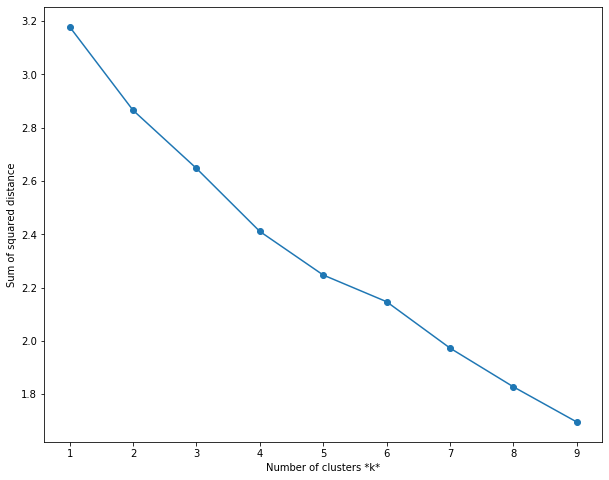

In [24]:
import matplotlib.pyplot as plt

kcount = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(man_grouped_clustering)
    kcount.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 8))
plt.plot(list_k, kcount, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [25]:
labels= kmeans.labels_ 

print(sklearn.metrics.silhouette_score(man_grouped_clustering, labels, metric='euclidean'))
print("at k=3 s-score is 0.0610")
print("at k=4 s-score is 0.0603")
print("at k=5 s-score is 0.0674")
print("at k=6 s-score is 0.0602")


0.05422331754198764
at k=3 s-score is 0.0610
at k=4 s-score is 0.0603
at k=5 s-score is 0.0674
at k=6 s-score is 0.0602


### 20. So here we have our basic output that we can use for visualization of the clusters:

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

man_merged = man_hoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
man_merged = man_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

man_merged.dropna(axis=0, inplace=True)
man_merged['Cluster Labels Int']= man_merged['Cluster Labels'].astype(int)+1
man_merged.reset_index(inplace=True, drop=True)
man_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common NextVenue,2nd Most Common NextVenue,3rd Most Common NextVenue,4th Most Common NextVenue,5th Most Common NextVenue,Cluster Labels Int
0,Manhattan,Washington Heights,40.851903,-73.936900,4.0,Grocery Store,Supermarket,Donut Shop,Café,Gym / Fitness Center,5
1,Manhattan,Inwood,40.867684,-73.921210,4.0,Wine Shop,Supermarket,Donut Shop,Park,Café,5
2,Manhattan,Hamilton Heights,40.823604,-73.949688,0.0,Sandwich Place,State / Provincial Park,Supermarket,Liquor Store,Donut Shop,1
3,Manhattan,Manhattanville,40.816934,-73.957385,3.0,American Restaurant,BBQ Joint,Ramen Restaurant,Sandwich Place,Grocery Store,4
4,Manhattan,Central Harlem,40.815976,-73.943211,1.0,Sandwich Place,Breakfast Spot,Park,Chinese Restaurant,Bank,2
5,Manhattan,East Harlem,40.792249,-73.944182,1.0,Park,Gym,Fried Chicken Joint,Supermarket,Bank,2
6,Manhattan,Upper East Side,40.775639,-73.960508,2.0,Grocery Store,Coffee Shop,Bagel Shop,Pharmacy,Art Museum,3
7,Manhattan,Yorkville,40.775930,-73.947118,4.0,Grocery Store,Supermarket,Park,Bagel Shop,Coffee Shop,5
8,Manhattan,Lenox Hill,40.768113,-73.958860,2.0,Pharmacy,Coffee Shop,Grocery Store,Non-Profit,Department Store,3
9,Manhattan,Upper West Side,40.787658,-73.977059,0.0,Coffee Shop,Grocery Store,Bookstore,Cosmetics Shop,Park,1


### 21. KMeans Clustering   
#### 1 = Orange 
#### 2 = Red 
#### 3 = Purple 
#### 4 = Light Blue 
#### 5 = Light Green

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(man_merged['Latitude'], man_merged['Longitude'], man_merged['Neighborhood'], man_merged['Cluster Labels Int']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        fill_color=rainbow[cluster-3],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
k1= man_merged.loc[man_merged['Cluster Labels Int'] == 1, man_merged.columns[[1] + list(range(5, man_merged.shape[1]))]]
print("Number of neighborhoods in this cluster out of 36 total:", k1['Neighborhood'].nunique())
k1

Number of neighborhoods in this cluster out of 36 total: 14


,Neighborhood,1st Most Common NextVenue,2nd Most Common NextVenue,3rd Most Common NextVenue,4th Most Common NextVenue,5th Most Common NextVenue,Cluster Labels Int
2,Hamilton Heights,Sandwich Place,State / Provincial Park,Supermarket,Liquor Store,Donut Shop,1
9,Upper West Side,Coffee Shop,Grocery Store,Bookstore,Cosmetics Shop,Park,1
11,Clinton,Wine Shop,Grocery Store,Health Food Store,Mexican Restaurant,Sandwich Place,1
15,Greenwich Village,Coffee Shop,Park,Grocery Store,Clothing Store,Vietnamese Restaurant,1
18,Tribeca,Sandwich Place,Bakery,Grocery Store,Playground,Park,1
21,West Village,Coffee Shop,Supermarket,Jazz Club,Bank,Bakery,1
22,Manhattan Valley,Grocery Store,Pharmacy,Coffee Shop,Supermarket,Park,1
23,Morningside Heights,Coffee Shop,Sandwich Place,Grocery Store,Deli / Bodega,Supermarket,1
24,Gramercy,Supermarket,Coffee Shop,Pharmacy,Park,Grocery Store,1
25,Battery Park City,Coffee Shop,Performing Arts Venue,Food Court,Movie Theater,Supermarket,1


In [29]:
k2= man_merged.loc[man_merged['Cluster Labels Int'] == 2, man_merged.columns[[1] + list(range(5, man_merged.shape[1]))]]
print("Number of neighborhoods in this cluster out of 36 total:", k2['Neighborhood'].nunique())
k2

Number of neighborhoods in this cluster out of 36 total: 5


,Neighborhood,1st Most Common NextVenue,2nd Most Common NextVenue,3rd Most Common NextVenue,4th Most Common NextVenue,5th Most Common NextVenue,Cluster Labels Int
4,Central Harlem,Sandwich Place,Breakfast Spot,Park,Chinese Restaurant,Bank,2
5,East Harlem,Park,Gym,Fried Chicken Joint,Supermarket,Bank,2
12,Midtown,Park,Plaza,Department Store,Pharmacy,Coffee Shop,2
14,Chelsea,Park,Market,Burger Joint,Electronics Store,Italian Restaurant,2
34,Flatiron,Park,Grocery Store,Cosmetics Shop,Coffee Shop,Movie Theater,2


In [30]:
k3= man_merged.loc[man_merged['Cluster Labels Int'] == 3, man_merged.columns[[1] + list(range(5, man_merged.shape[1]))]]
print("Number of neighborhoods in this cluster out of 36 total:", k3['Neighborhood'].nunique())
k3

Number of neighborhoods in this cluster out of 36 total: 12


,Neighborhood,1st Most Common NextVenue,2nd Most Common NextVenue,3rd Most Common NextVenue,4th Most Common NextVenue,5th Most Common NextVenue,Cluster Labels Int
6,Upper East Side,Grocery Store,Coffee Shop,Bagel Shop,Pharmacy,Art Museum,3
8,Lenox Hill,Pharmacy,Coffee Shop,Grocery Store,Non-Profit,Department Store,3
10,Lincoln Square,Grocery Store,Movie Theater,Pharmacy,Coffee Shop,Plaza,3
13,Murray Hill,Pharmacy,Grocery Store,Coffee Shop,Multiplex,Park,3
17,Lower East Side,Art Gallery,Bagel Shop,Pharmacy,Supermarket,Pizza Place,3
19,Little Italy,Coffee Shop,Salad Place,Furniture / Home Store,Mexican Restaurant,Miscellaneous Shop,3
20,Soho,Grocery Store,Furniture / Home Store,Clothing Store,Coffee Shop,Salad Place,3
26,Financial District,Coffee Shop,Mexican Restaurant,Department Store,Park,Monument / Landmark,3
29,Civic Center,Park,Coffee Shop,Grocery Store,Plaza,Monument / Landmark,3
30,Midtown South,Plaza,Department Store,Coffee Shop,Park,Shopping Mall,3


In [31]:
k4= man_merged.loc[man_merged['Cluster Labels Int'] == 4, man_merged.columns[[1] + list(range(5, man_merged.shape[1]))]]
print("Number of neighborhoods in this cluster out of 36 total:", k4['Neighborhood'].nunique())
k4

Number of neighborhoods in this cluster out of 36 total: 1


,Neighborhood,1st Most Common NextVenue,2nd Most Common NextVenue,3rd Most Common NextVenue,4th Most Common NextVenue,5th Most Common NextVenue,Cluster Labels Int
3,Manhattanville,American Restaurant,BBQ Joint,Ramen Restaurant,Sandwich Place,Grocery Store,4


In [32]:
k5= man_merged.loc[man_merged['Cluster Labels Int'] == 5, man_merged.columns[[1] + list(range(5, man_merged.shape[1]))]]
print("Number of neighborhoods in this cluster out of 36 total:", k5['Neighborhood'].nunique())
k5

Number of neighborhoods in this cluster out of 36 total: 4


,Neighborhood,1st Most Common NextVenue,2nd Most Common NextVenue,3rd Most Common NextVenue,4th Most Common NextVenue,5th Most Common NextVenue,Cluster Labels Int
0,Washington Heights,Grocery Store,Supermarket,Donut Shop,Café,Gym / Fitness Center,5
1,Inwood,Wine Shop,Supermarket,Donut Shop,Park,Café,5
7,Yorkville,Grocery Store,Supermarket,Park,Bagel Shop,Coffee Shop,5
16,East Village,Grocery Store,Park,Coffee Shop,Pharmacy,Fast Food Restaurant,5


### 22. After examining the clusters, I wanted to explore a granular example of neighboring independent and chain pharmacies. 
#### To do so, I merge the the dataset with the "Chain/Indpendent" distinction to the NextVenues dataset, based on the "Venue Id" of the pharmacy from the intital Venue datadet.

In [33]:
inner_join= pd.DataFrame(pd.merge(man_nextvenues,man_newvenues1, on='Venue Id', how='inner'))
indep_sample= pd.DataFrame(inner_join[inner_join['Venue']== 'Kings Pharmacy'])
indep_sample

,Neighborhood_x,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Chain/Indep,Neighborhood_y,Pharmacy,NextVenue,NextVenue Latitude,NextVenue Longitude,NextVenue Category
509,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Whole Foods Market,40.715579,-74.011368,Grocery Store
510,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Morgan's Market,40.716298,-74.009294,Deli / Bodega
511,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Duane Reade,40.719183,-74.010775,Pharmacy
512,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Bed Bath & Beyond,40.715807,-74.011804,Furniture / Home Store
513,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Bogardus Plaza,40.715962,-74.009064,Plaza


In [34]:
chain_sample= pd.DataFrame(inner_join[inner_join['Venue Longitude']<= -74.010775])
chain_sample.head()

,Neighborhood_x,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Chain/Indep,Neighborhood_y,Pharmacy,NextVenue,NextVenue Latitude,NextVenue Longitude,NextVenue Category
340,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Whole Foods Market,40.715579,-74.011368,Grocery Store
341,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Benvenuto Cafe Tribeca,40.719503,-74.010269,Sandwich Place
342,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Pier 25 - Hudson River Park,40.720193,-74.012950,Park
343,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Maison Kayser,40.718909,-74.010331,Bakery
344,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Washington Market Park,40.717046,-74.011095,Playground


In [35]:
sample_cords= indep_sample.append(chain_sample)
s1= pd.DataFrame(sample_cords.head(10))
print(s1.shape)
s1

(10, 15)


,Neighborhood_x,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Chain/Indep,Neighborhood_y,Pharmacy,NextVenue,NextVenue Latitude,NextVenue Longitude,NextVenue Category
509,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Whole Foods Market,40.715579,-74.011368,Grocery Store
510,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Morgan's Market,40.716298,-74.009294,Deli / Bodega
511,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Duane Reade,40.719183,-74.010775,Pharmacy
512,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Bed Bath & Beyond,40.715807,-74.011804,Furniture / Home Store
513,Civic Center,40.715229,-74.005415,3fd66200f964a5208be61ee3,Kings Pharmacy,40.715822,-74.009238,Pharmacy,Independent,Civic Center,Kings Pharmacy,Bogardus Plaza,40.715962,-74.009064,Plaza
340,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Whole Foods Market,40.715579,-74.011368,Grocery Store
341,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Benvenuto Cafe Tribeca,40.719503,-74.010269,Sandwich Place
342,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Pier 25 - Hudson River Park,40.720193,-74.012950,Park
343,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Maison Kayser,40.718909,-74.010331,Bakery
344,Tribeca,40.721522,-74.010683,4b201815f964a5201d2d24e3,Duane Reade,40.719183,-74.010775,Pharmacy,Chain,Tribeca,Duane Reade,Washington Market Park,40.717046,-74.011095,Playground


### 23. To visualize, I extract each pharmacy's coordinates.

In [36]:
kp_lat= s1.loc[509].at['Venue Latitude']
kp_lng= s1.loc[509].at['Venue Longitude']
kp= [kp_lat, kp_lng]

dr_lat= s1.loc[340].at['Venue Latitude']
dr_lng= s1.loc[340].at['Venue Longitude']
dr= [dr_lat, dr_lng]

print(kp, dr)


[40.715821999999996, -74.009238] [40.719182554541575, -74.01077548633106]


### 24. I wanted to set a good closeup view on the map, so I used the mean lat and long of both pharmacies. Also, the marker colors are the same as the previous "Chain/Independent" Manhattan map: Red = Independent, Blue = Chain.
#### Notice that a NextVenue for the independent pharmacy is the chain pharmacy(!) and, they both share the same grocery store (Whole Foods). Click on the markers to see more.

In [37]:
lat= (dr_lat+kp_lat)/2
lng= (dr_lng+kp_lng)/2

# create map
map_cc_sample = folium.Map(location=[lat, lng], zoom_start=16)
folium.CircleMarker(dr, radius=10, color='blue', fill=True, fill_color='blue', fill_opacity=0.8, popup='CHAIN, Duane Reade').add_to(map_cc_sample)
folium.CircleMarker(kp, radius=10, color='red', fill=True, fill_color='red', fill_opacity=0.8, popup='INDEPENDENT, Kings Pharmacy').add_to(map_cc_sample)

for lat, lng, venue, kind in zip(s1['NextVenue Latitude'], s1['NextVenue Longitude'], s1['NextVenue'], s1['Chain/Indep']):
    label = folium.Popup(str(venue), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8 if kind == 'Independent' else 6,
        popup=label,
        color= 'red' if kind == 'Independent' else 'blue',
        fill=True,
        fill_color= 'red' if kind == 'Independent' else 'blue',
        fill_opacity=0.3,
        parse_html=False).add_to(map_cc_sample) 


map_cc_sample

### 25. To visualize the "Top 10" NextVenue categories, I took the sum values from the one-hot dataframe, sorted them by descening order, then added the count of all categories after the ninth most frequent so that it could be visualized as "Other".

In [38]:
df2= man_onehot.sum()
df2= pd.DataFrame(df2, columns=['Frequency'])
df2.drop(index= 'Neighborhood', inplace=True)
df2.sort_values('Frequency', ascending=False, inplace=True)
df2.reset_index(inplace=True)
df2.rename(columns= {"index":"NextVenue Category"}, inplace=True)
df3= df2.head(9)
df3

,NextVenue Category,Frequency
0,Grocery Store,69
1,Coffee Shop,57
2,Park,46
3,Supermarket,41
4,Pharmacy,37
5,Department Store,21
6,Plaza,17
7,Sandwich Place,14
8,Deli / Bodega,10


In [39]:
df4= df2.loc[9:,:]
print(df4.tail())
other_total= (df4['Frequency'].sum())
print(other_total)
df3= df3.append({'NextVenue Category':'Other', 'Frequency':209}, ignore_index=True)
df3

               NextVenue Category Frequency
79            Fried Chicken Joint         1
80  Paper / Office Supplies Store         1
81                   Burger Joint         1
82          Performing Arts Venue         1
83                Harbor / Marina         1
210


,NextVenue Category,Frequency
0,Grocery Store,69
1,Coffee Shop,57
2,Park,46
3,Supermarket,41
4,Pharmacy,37
5,Department Store,21
6,Plaza,17
7,Sandwich Place,14
8,Deli / Bodega,10
9,Other,209


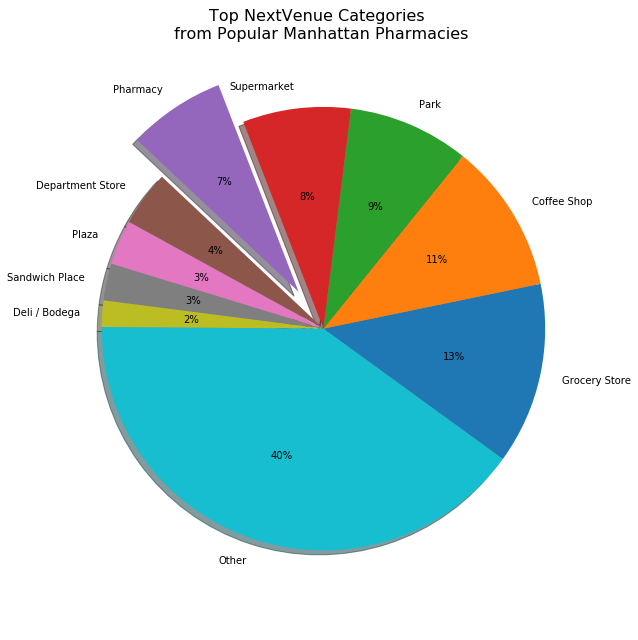

In [40]:


labels = df3['NextVenue Category']
sizes = df3['Frequency']
explode = (0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0)  
title= 'Top NextVenue Categories \n from Popular Manhattan Pharmacies'

fig1, ax1 = plt.subplots(figsize= (9,9))
ax1.pie(sizes, labels=labels, autopct='%1.f%%',
        shadow=True, startangle=324, explode=explode)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

### 26. I found it interesting that the fifth most frequent NextVenue Category was another pharmacy. I want to explore this further. 
#### First thing is to visualize it to see which pharmacies are the "NextVenues to the Venues".

In [41]:
df_nvpharm= pd.DataFrame(inner_join[inner_join['NextVenue Category']== 'Pharmacy'])
df_nvpharm.drop(columns=['Venue Category', 'Neighborhood_y', 'Pharmacy'], inplace=True)
df_nvpharm.reset_index(drop=True, inplace=True)
df_nvpharm.head()

,Neighborhood_x,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Chain/Indep,NextVenue,NextVenue Latitude,NextVenue Longitude,NextVenue Category
0,Upper East Side,40.775639,-73.960508,4b676969f964a5204f4d2be3,CVS pharmacy,40.778350,-73.956351,Chain,Duane Reade,40.777980,-73.956443,Pharmacy
1,Upper East Side,40.775639,-73.960508,4b5cd51cf964a520454629e3,Duane Reade,40.777980,-73.956443,Chain,CVS pharmacy,40.778350,-73.956351,Pharmacy
2,Yorkville,40.775930,-73.947118,5aef0c73491be7002ccf7b61,CVS pharmacy,40.778029,-73.951616,Chain,Duane Reade,40.776957,-73.949068,Pharmacy
3,Yorkville,40.775930,-73.947118,4bb1562ff964a520348d3ce3,Duane Reade,40.776406,-73.947014,Chain,Duane Reade,40.776957,-73.949068,Pharmacy
4,Lenox Hill,40.768113,-73.958860,4b32a3d6f964a520ae1025e3,CVS pharmacy,40.769162,-73.958060,Chain,Duane Reade,40.767964,-73.955498,Pharmacy


In [42]:
print("Number of pharmacies with other pharmacies as a top nextvenue category:", df_nvpharm['Venue Id'].nunique())
print("Neighborhoods with those pharmacies:")
nvpharm1= df_nvpharm.groupby(df_nvpharm['Neighborhood_x']).count().sort_values('NextVenue', ascending=False)
print(nvpharm1.shape)
nvpharm1.head()

Number of pharmacies with other pharmacies as a top nextvenue category: 31
Neighborhoods with those pharmacies:
(17, 11)


,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Chain/Indep,NextVenue,NextVenue Latitude,NextVenue Longitude,NextVenue Category
Neighborhood_x,,,,,,,,,,,
Murray Hill,7,7,7,7,7,7,7,7,7,7,7
Lenox Hill,5,5,5,5,5,5,5,5,5,5,5
Tudor City,4,4,4,4,4,4,4,4,4,4,4
Gramercy,3,3,3,3,3,3,3,3,3,3,3
Lincoln Square,3,3,3,3,3,3,3,3,3,3,3


### 27. To distingish between the Venue Pharmacy and the NextVenue Pharmacy, the Venue Pharmacy is represented by the blue location marker icons, and its NextVenue are represented by the purple CircleMarkers. 
#### I also added a loop function to include red PolyLines between each Venue and NextVenue. The surprising insight: these pharmacies are Venues and NextVenues to each other! 

In [43]:
# create map
map_nvpharm = folium.Map(location=[latitude-.03, longitude], zoom_start=14)



for hood, lat, lng, venue, in zip(df_nvpharm['Neighborhood_x'], df_nvpharm['Venue Latitude'], df_nvpharm['Venue Longitude'], df_nvpharm['Venue']):
        label = folium.Popup(str(venue) + ' in ' + str(hood), parse_html=True)
        folium.Marker(
            [lat, lng],
            popup=label,
        ).add_to(map_nvpharm) 


for nhood, nvlat, nvlng, nvenue, vvenue, in zip(df_nvpharm['Neighborhood_x'], df_nvpharm['NextVenue Latitude'], df_nvpharm['NextVenue Longitude'], 
                                                df_nvpharm['NextVenue'], df_nvpharm['Venue']):
        label = folium.Popup(str(nvenue) + ' visited AFTER ' +  str(vvenue) + ' in ' + str(nhood), parse_html=True)
        folium.CircleMarker(
            [nvlat, nvlng],
            radius=9,
            popup=label,
            color= 'purple',
            fill=True,
            fill_color= 'purple',
            fill_opacity=0.9,
            parse_html=False).add_to(map_nvpharm) 
        
for lat, lng, nvlat, nvlng in zip(df_nvpharm['Venue Latitude'], df_nvpharm['Venue Longitude'],  df_nvpharm['NextVenue Latitude'], df_nvpharm['NextVenue Longitude']):
        folium.PolyLine([[lat, lng],[nvlat, nvlng]], color="red", weight=2.5, opacity=1).add_to(map_nvpharm)


map_nvpharm

### 28. After reviewing the map, my hypothesis is that hospitals and centrally planned complexes have an inherent relationship with NextVenue pharmacies. 
#### Let's test the hypothesis by retrieving hopspitals in each neighborhood through Foursquare's API using Search Endpoint Query.

In [19]:
CATEGORY_ID1= '4bf58dd8d48988d196941735'
RADIUS1= 500

def getNearbyVenues2(names, latitudes, longitudes):
    
    venues_list2=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            CATEGORY_ID1,
            RADIUS1
            )
            
        # make the GET request
        results2 = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list2.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results2])

    nearby_venues2 = pd.DataFrame([item for venue_list2 in venues_list2 for item in venue_list2])
    nearby_venues2.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues2) 

In [20]:
man_venues2 = getNearbyVenues2(names=man_hoods['Neighborhood'],
                               latitudes=man_hoods['Latitude'],
                               longitudes=man_hoods['Longitude']
                              )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [25]:
print(man_venues2.shape)
man_venues2.to_csv(r'Coursera_Capstone\man_venues2.csv',index=False)

(300, 8)


### 29. Like the other API call outputs, I exported the dataframe to a static csv.

In [80]:
man_venues2= pd.read_csv('Coursera_Capstone\man_venues2.csv')
df_hosp= man_venues2.groupby(['Neighborhood']).count().sort_values('Venue', ascending=False)
print(df_hosp.shape)
df_hosp.head()
df_hosp1= pd.DataFrame(df_hosp['Venue'])
df_hosp1.head()

(39, 7)


,Venue
Neighborhood,
Gramercy,30
Lenox Hill,30
Roosevelt Island,30
Tudor City,23
Sutton Place,17


### 30. For consistency, I dropped Roosevelt Island, Chinatown, and Stuyvesant Town from the index because we dataset because we do not have NextVenue data on this neighborhood and dropped them from previous analysis.

In [81]:
df_hosp1.drop(['Roosevelt Island', 'Chinatown', 'Stuyvesant Town'], inplace=True)
print(df_hosp1.shape)

(36, 1)


### 31. Before running a simple linear regression prediction model, let's plot the known data and calculate the correlation. Each blue dot represents a neighborhood.

In [82]:
nvpharm2= nvpharm1['Venue']
df_hosp1['NextVenues']= nvpharm2
df_hosp1.fillna(0, inplace=True)
df_hosp1.reset_index(inplace=True)


print(df_hosp1.shape)
df_hosp1.head()

(36, 3)


,Neighborhood,Venue,NextVenues
0,Gramercy,30,3.0
1,Lenox Hill,30,5.0
2,Tudor City,23,4.0
3,Sutton Place,17,2.0
4,Murray Hill,15,7.0


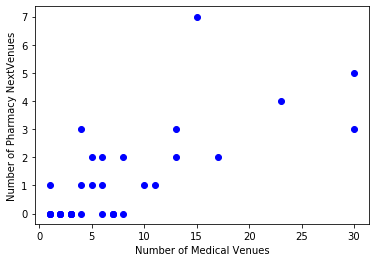

In [83]:
x= df_hosp1.Venue
y= df_hosp1.NextVenues


plt.scatter(x,y,c='b') 
plt.ylabel("Number of Pharmacy NextVenues")
plt.xlabel("Number of Medical Venues")
plt.show()

### 32. I also replotted the above but rendered neighborhoods where y=0 (that is, neighborhoods without pharmacy NextVenues) as red. This helps vizualize the distingishing 0/1 data for classification models below.

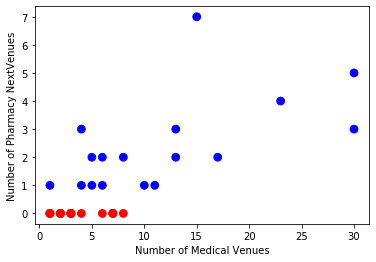

In [84]:
x= df_hosp1.Venue
y= df_hosp1.NextVenues

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==0:
            cols.append('red')
        else:
            cols.append('blue')
    return cols

cols= pltcolor(y)
plt.scatter(x,y,c=cols, s=60) 
plt.ylabel("Number of Pharmacy NextVenues")
plt.xlabel("Number of Medical Venues")
plt.show()

In [85]:
df_feat = pd.DataFrame(df_hosp1)
df_feat1 = df_feat[(df_feat[['NextVenues']] != 0).all(axis=1)]
df_feat1.reset_index(inplace=True, drop=True)
print(df_feat1.shape)
df_feat1.head()

(17, 3)


,Neighborhood,Venue,NextVenues
0,Gramercy,30,3.0
1,Lenox Hill,30,5.0
2,Tudor City,23,4.0
3,Sutton Place,17,2.0
4,Murray Hill,15,7.0


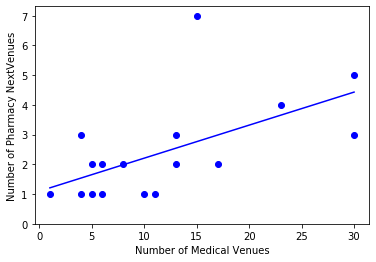

In [86]:
from numpy.polynomial.polynomial import polyfit

plt.scatter(df_feat1.Venue, df_feat1.NextVenues,  color= 'blue')
b, m = polyfit(df_feat1.Venue, df_feat1.NextVenues, 1)
plt.plot(df_feat1.Venue, b + m * df_feat1.Venue, '-', color='blue')
plt.yticks((0, 1, 2, 3, 4, 5, 6, 7))
plt.ylabel("Number of Pharmacy NextVenues")
plt.xlabel("Number of Medical Venues")
plt.show()

In [107]:
X0= df_hosp1['Venue']
Y0= df_hosp1['NextVenues']

X3= df_feat1['Venue']
Y3= df_feat1['NextVenues']

print("Pearson corr with all neighborhoods:", (X0.corr(Y0)**2).round(3), Y0.corr(X0).round(3))
print("Pearson corr with neighborhoods excluding where y=0:", X3.corr(Y3).round(3), Y3.corr(X3).round(3))

Pearson corr with all neighborhoods: 0.536 0.732
Pearson corr with neighborhoods excluding where y=0: 0.59 0.59


In [88]:
X1= np.asanyarray(df_feat1[['Venue']])
Y1= np.asanyarray(df_feat1[['NextVenues']])

### 32. Setting up the train/test split and fitting the model-- I set the training set at 75% of the data set

In [89]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X1, Y1, test_size=0.25, random_state=0)

In [90]:
regr = linear_model.LinearRegression()
regr.fit (train_x, train_y)

print ('Simple Lin Coefficients: ', regr.coef_)
print ('Simple Lin Intercept: ',regr.intercept_)

Simple Lin Coefficients:  [[0.10038496]]
Simple Lin Intercept:  [1.2873359]


### 33. Plot the training results-- a positive correlation line is apparent from the mean-squares line.

Text(0.5, 0, 'Number of Hospital Sites')

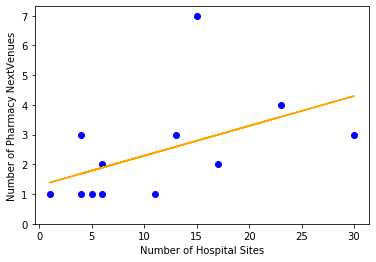

In [91]:
plt.scatter(train_x, train_y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], 'orange')
plt.ylabel("Number of Pharmacy NextVenues")
plt.yticks((0, 1, 2, 3, 4, 5, 6, 7))
plt.xlabel("Number of Hospital Sites")

### 34. Now we evaluate the model by calculating the Mean Absolute Error, the Mean Squares Error, and the R-Squared.
#### With an r^2 of 0.34, the model is shows a weak relationship for predicting the number of hospitals and pharmacies that are NextVenues to each other within the same neighborhood. The report discusses this further.

In [92]:
test_y_hat = regr.predict(test_x)

In [93]:
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Mean Squared Error: %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat,test_y ) )

Mean absolute error: 0.58
Mean Squared Error: 0.51
R2-score: 0.34


### 35. Categorical prediction models for determining presence of pharmacy NextVenues (y) depending on number of medical venues in that neighborhood (x)
#### First, we need to add a column that classifies our y from the presence of NextVenues. See column "nvint" below.

In [175]:
df_hosp2= df_hosp1
nvbool= df_hosp2['NextVenues'].astype(bool)
nvint= nvbool.astype(int)
df_hosp2['nvint']= nvint
df_hosp2.drop(columns= 'NextVenues', inplace=True)
df_hosp2.head()

,Neighborhood,Venue,nvint
0,Gramercy,30,1
1,Lenox Hill,30,1
2,Tudor City,23,1
3,Sutton Place,17,1
4,Murray Hill,15,1


### 36. Now we split the data for train test splitting. Because there is only one feature, we won't need to normalize the data. 

In [197]:
X2= np.asarray(df_hosp2[['Venue']])
Y2= np.asarray(df_hosp2[['nvint']])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X2, Y2, test_size=0.3, random_state=0)

### 37. Now we run Logistic regression model under liblinear with regularization factor of .01
#### We also run evaluation metrics below

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train1, y_train1.ravel())
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [123]:
yhat = LR.predict(X_test1)
yhat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [124]:
yhat_prob = LR.predict_proba(X_test1)
yhat_prob

array([[0.48440005, 0.51559995],
       [0.41302198, 0.58697802],
       [0.36721165, 0.63278835],
       [0.46038929, 0.53961071],
       [0.43656097, 0.56343903],
       [0.36721165, 0.63278835],
       [0.32368051, 0.67631949],
       [0.1013566 , 0.8986434 ],
       [0.34512152, 0.65487848],
       [0.46038929, 0.53961071],
       [0.46038929, 0.53961071]])

In [125]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test1, yhat)

0.36363636363636365

In [126]:
from sklearn.metrics import log_loss
log_loss(y_test1, yhat_prob)

0.7372027271561209

In [127]:
from sklearn.metrics import classification_report
print (classification_report(y_test1, yhat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.36      1.00      0.53         4

   micro avg       0.36      0.36      0.36        11
   macro avg       0.18      0.50      0.27        11
weighted avg       0.13      0.36      0.19        11



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 38. We also run a SVM model under rbf kernel.
#### We also run evaluation metrics below. This model has better predictability than logistic regression model.

In [198]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma='auto')
clf.fit(X_train1, y_train1.ravel()) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [199]:
yhat1 = clf.predict(X_test1)
yhat1 

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0])

In [200]:
print(jaccard_similarity_score(y_test1, yhat1))
print((classification_report(y_test1, yhat1)))

0.7272727272727273
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.60      0.75      0.67         4

   micro avg       0.73      0.73      0.73        11
   macro avg       0.72      0.73      0.72        11
weighted avg       0.75      0.73      0.73        11



### 39. The below visualizes the SVM training and test set outputs 
#### I used a library called mlxtend from doing further research on plotting decision regions on SVM outputs.

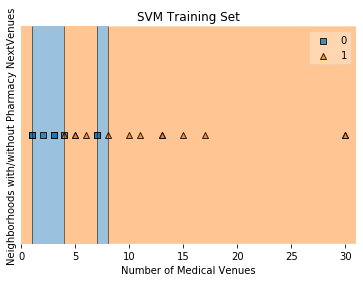

In [203]:
X6 = X_train1
y6 = y_train1.ravel()

plot_decision_regions(X6, y6, clf=clf, legend=1)

plt.xlabel('Number of Medical Venues')
plt.ylabel('Neighborhoods with/without Pharmacy NextVenues')
plt.title('SVM Training Set')
plt.show()

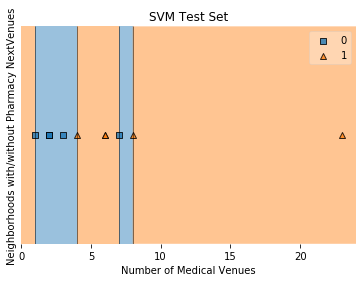

In [202]:
plot_decision_regions(X_test1, yhat1, clf, legend=1)

plt.xlabel('Number of Medical Venues')
plt.ylabel('Neighborhoods with/without Pharmacy NextVenues')
plt.title('SVM Test Set')
plt.show()